# Sentinel-2 NDVI timeseries using Google Earth Engine

This demo gives an overview of calculating a time series of spectral indices using Sentinel-2 data. It uses the Google Earth Engine (GEE) API package for python. This allows to compute large amount of satellite (and other remote sensing) data without having to download the huge data sets. To be able to use this package a GEE account is required.

### Start a GEE session

The first time the "ee" package is used, you need to run ee.Authenticate(). This will open a window on the web where you have to log in with your GEE credentials. This will create an access token that needs to be pasted in the box that appeared below (this needs to be done at the beginning or when the kernel/session is restarted). To start the connection with your GEE account, you run ee.Initialize(). If you have only one project on your GEE account, you do not need to specify more. If you have multiple projects, you can specify with ee.Initialize(project=project-number). To find the project number, you have to log in to GEE online and click on the respective project.

In [147]:
# Load the packages
import ee       # GEE API package
import geemap   # package for interactive plotting->does not work on PyCharm
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.dates as mdates

# Login with the GEE credentials and connect to your account
ee.Authenticate()   # needs to be done once in a while
ee.Initialize()     # starts the connection to your GEE account and allows you to use all the datasets you might have stored there

---

### Define the study areas

For the NDVI time series, we select two different forest types (deciduous broadleaf: "db", evergreen coniferous: "ec") and an agricultural area: "agr" in Switzerland. For each site, we define one point with coordinates and use a buffer to get a circular area of interest. 

In [148]:
# Define the points for each of the AOIs
point_db = ee.Geometry.Point([8.3634171, 47.4788405])
point_ec = ee.Geometry.Point([9.85509283, 46.81539482])
point_agr = ee.Geometry.Point([7.733592499218185, 47.286134852362366])

# Apply a buffer around the defined points. The "buffer number" is the radius of the circle in meters.
aoi_db = point_db.buffer(30)
aoi_ec = point_ec.buffer(30)
aoi_agr = point_agr.buffer(30)

We can visualize the three areas on a map. The three AOIs are situated where the University of Zürich (and other institutions) have in situ instrumentation: Laegern near Zurich and Baden (deciduous broadleaf), Davos (evergreen coniferous), and Oensingen (agriculture).

In [149]:
# Initialize the map
Map = geemap.Map()

# Define how the basemap should be displayed
Map.set_center(9.85, 46.82, 13) # coordinates and zoom
Map.add_basemap('TERRAIN')      # can also be "SATELLITE" 

# Define the visualization parameters for the AOI, such as color (as hex-code)
vis_params = {'color': '#d515c5',
              'pointSize': 3,
              'pointShape': 'circle',
              'width': 2,
              'lineType': 'solid',
              'lineType': 'solid'}

# Add the area of interests as polygons to the map
Map.addLayer(aoi_db, vis_params, 'db')
Map.addLayer(aoi_ec, vis_params, 'ec')
Map.addLayer(aoi_agr, vis_params, 'agr')

# Display the map
Map

Map(center=[46.82, 9.85], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

---

### Data selection

We will work with the Sentinel-2 L2A Bottom-of-Atmosphere reflectance data ImageCollection, as well as the cloud score + ImageCollection for cloud masking. This is an important step to select only valid pixels in the available Sentinel-2 images for the time series analysis. We filter the two Collections by date (e.g., 1 year) and the respective AOIs and add bands from the cloud score + Collection to the Sentinel-2 ImageCollection (by using "linkCollection"). We can then display the number of available images for the respective AOIs in the selected time frame. E.g., during 2023, twice as many images are available for Laegern and Oensingen (Swiss Mittelland) as for Davos (Swiss Alps). We selected 2023 as it has a big amount of usable images. You can also change the years and duration of the study period to explore the differences.

In [150]:
# Define the study period
startTime = '2023-01-01'
endTime = '2023-12-31'

#-------------------------
# AOI deciduous broadleaf:
#-------------------------
# Filter the Sentinel-2 cloud score+ (for cloud filtering) by date and AOI
db_csp = ee.ImageCollection('GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED')\
    .filter(ee.Filter.bounds(aoi_db))\
    .filter(ee.Filter.date(startTime, endTime))

# Add the cloud score+ bands "cs_cdf" and "cs" to the filtered Sentinel-2 image collection
db_S2= ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')\
    .filter(ee.Filter.bounds(aoi_db))\
    .filter(ee.Filter.date(startTime, endTime))\
    .linkCollection(db_csp, ['cs_cdf','cs'])

#-------------------------
# AOI evergreen coniferous:
#-------------------------
# Filter the Sentinel-2 cloud score+ (for cloud filtering) by date and AOI
ec_csp = ee.ImageCollection('GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED')\
    .filter(ee.Filter.bounds(aoi_ec))\
    .filter(ee.Filter.date(startTime, endTime))

# Add the cloud score+ bands "cs_cdf" and "cs" to the filtered Sentinel-2 image collection
ec_S2= ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')\
    .filter(ee.Filter.bounds(aoi_ec))\
    .filter(ee.Filter.date(startTime, endTime))\
    .linkCollection(ec_csp, ['cs_cdf','cs'])

#-------------------------
# AOI agricultural area:
#-------------------------
# Filter the Sentinel-2 cloud score+ (for cloud filtering) by date and AOI
agr_csp = ee.ImageCollection('GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED')\
    .filter(ee.Filter.bounds(aoi_agr))\
    .filter(ee.Filter.date(startTime, endTime))

# Add the cloud score+ bands "cs_cdf" and "cs" to the filtered Sentinel-2 image collection
agr_S2= ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')\
    .filter(ee.Filter.bounds(aoi_agr))\
    .filter(ee.Filter.date(startTime, endTime))\
    .linkCollection(agr_csp, ['cs_cdf','cs'])
              
# Check how many images are in the collection for each AOI
print('Number of images in study period for Laegern:', db_S2.size().getInfo())  
print('Number of images in study period for Davos:', ec_S2.size().getInfo()) 
print('Number of images in study period for Oensingen:', agr_S2.size().getInfo()) 

Number of images in study period for Laegern: 147
Number of images in study period for Davos: 73
Number of images in study period for Oensingen: 146


---

### Cloud and Cloud Shadow Masking

We will now define a function for cloud and cloud shadow masking of the Sentinel-2 images, which we will then apply to each of our filtered ImageCollections from the step before. This will mask pixels in the images that are covered by clouds or cloud shadows. Images with all pixels of the AOI masked will still remain in the ImageCollection.

In [151]:
# Define a function to mask clouds and cloud shadows

def maskCloudsAndShadows(image):

    # get the solar position of each image in the collection
    meanAzimuth = image.get('MEAN_SOLAR_AZIMUTH_ANGLE')
    meanZenith = image.get('MEAN_SOLAR_ZENITH_ANGLE')

    # get the cloud score layer
    clouds_csp = image.select('cs_cdf')  # Pixel quality score (0-1): 0 = cloudy, 1 = clear
    
    # the maximum clear sky probability threshold is set at 60% (change this number to filter more/less images)
    cloudMask_csp = clouds_csp.gte(0.6)
    
    # define potential cloud shadow values
    cloudShadowMask_csp = clouds_csp.gte(0.60).And(clouds_csp.lte(0.80))
    
    # Project shadows from clouds. This step assumes we're working in a UTM projection.
    shadowAzimuth = ee.Number(90).subtract(ee.Number(meanAzimuth))
    
    # shadow distance is tied to the solar zenith angle (minimum shadowDistance is 30 pixel)
    shadowDistance = ee.Number(meanZenith).multiply(0.7).floor().int().max(30)
    
    # With the following algorithm, cloud shadows are projected
    isCloud_csp = cloudMask_csp.directionalDistanceTransform(shadowAzimuth, shadowDistance)
    isCloud_csp = isCloud_csp.reproject(crs=image.select('B2').projection(), scale=100)
    cloudShadow_csp = isCloud_csp.select('distance').mask()
    
    # combine projectedShadows & darkPixel and buffer the cloud shadow
    cloudShadow_csp = cloudShadow_csp.And(cloudShadowMask_csp).focalMax(100, 'circle', 'meters', 1, None)
    
    # combined mask for clouds and cloud shadows
    cloudAndCloudShadowMask_csp = cloudShadow_csp.Or(cloudMask_csp.Not())
    
    # mask spectral bands for clouds and cloudShadows,
    image_out = image.select(['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12'])\
        .updateMask(cloudAndCloudShadowMask_csp.Not())
    
    # adding two additional bands: S2 cloud score plus cloud probability and cloudAndCloudShadowMask
    image_out = image_out.addBands(clouds_csp.multiply(-1).add(1).rename(['cloudProbability']))\
        .addBands(cloudAndCloudShadowMask_csp.rename(['cloudAndCloudShadowMask']))
    
    return image_out    

In [152]:
# Apply the cloud mask function on the ImageCollection for each AOI
db_S2_cf = db_S2.map(maskCloudsAndShadows)
ec_S2_cf = ec_S2.map(maskCloudsAndShadows)
agr_S2_cf = agr_S2.map(maskCloudsAndShadows)

### Filter Images with less then a certain amount of valid (not masked) pixels in the AOI

As mentioned above, images remain in the ImageCollection even if all pixels of the AOI are masked out due to clouds. We can use the number of pixels within the respective AOIs to filter images from the Collection that have fewer than a certain number of pixels. For this, we need to count the number of valid pixels in the AOIs in each image of the ImageCollection and then define a threshold.

In [153]:
# Define a function to count the number of pixels in the AOI
# We can choose from which band the pixels should be counted (matters especially as not all bands have the same spatial resolution and
# hence have different pixel count). We select B8 as we also use this band to calculate the NDVI later. The "scale" defines the spatial 
# resolution we want the pixels counted. 10m is the resolution of B8.

def countValPixels(image, aoi):
    pixels = image.select('B8').reduceRegion(
        reducer=ee.Reducer.count(),
        geometry=aoi,
        scale=10)
    return image.set('valPixels', pixels.get('B8'))

In [154]:
# Use the function above together with ".map()" to add the pixel count as a new property to each of the images in the Collections
# We need to use a "lambda function" as the function we wrote uses two inputs and .map() can only handle one.
db_S2_cf = db_S2_cf.map(lambda image: countValPixels(image, aoi_db))
ec_S2_cf = ec_S2_cf.map(lambda image: countValPixels(image, aoi_ec))
agr_S2_cf = agr_S2_cf.map(lambda image: countValPixels(image, aoi_agr))

We can test whether the function worked by looking at, for example, the first 15 pixel count values of the ImageCollection. This also gives an indication of the threshold we should select. For the db Laegern site, the first few images are not useful as the AOI is masked. But we can assume that the AOI is 28 pixels big, as this is the maximum number we encounter. For the ec Davos site, the maximum number of pixels is 26 pixels even if we selected the same radius for the AOI generation.

In [155]:
print("\nPrinting the 'valPixels' property for the first 15 images:")
count = 1
for image in agr_S2_cf.toList(15).getInfo():  # change the image collections for each AOI and the number of images here
    image_id = image['id']
    pixel_count = image['properties']['valPixels']
    print(f"  - Image ID: {image_id}, Pixel Count: {pixel_count}")
    count += 1


Printing the 'valPixels' property for the first 15 images:
  - Image ID: COPERNICUS/S2_SR_HARMONIZED/20230104T103329_20230104T103331_T32TLT, Pixel Count: 0
  - Image ID: COPERNICUS/S2_SR_HARMONIZED/20230104T103329_20230104T103331_T32TMT, Pixel Count: 0
  - Image ID: COPERNICUS/S2_SR_HARMONIZED/20230109T103421_20230109T103416_T32TLT, Pixel Count: 0
  - Image ID: COPERNICUS/S2_SR_HARMONIZED/20230109T103421_20230109T103416_T32TMT, Pixel Count: 0
  - Image ID: COPERNICUS/S2_SR_HARMONIZED/20230114T103309_20230114T103304_T32TLT, Pixel Count: 0
  - Image ID: COPERNICUS/S2_SR_HARMONIZED/20230114T103309_20230114T103304_T32TMT, Pixel Count: 0
  - Image ID: COPERNICUS/S2_SR_HARMONIZED/20230119T103341_20230119T103728_T32TLT, Pixel Count: 28
  - Image ID: COPERNICUS/S2_SR_HARMONIZED/20230119T103341_20230119T103728_T32TMT, Pixel Count: 28
  - Image ID: COPERNICUS/S2_SR_HARMONIZED/20230124T103229_20230124T103227_T32TLT, Pixel Count: 0
  - Image ID: COPERNICUS/S2_SR_HARMONIZED/20230124T103229_2023012

In [156]:
# Filter images from the Collection where the pixel number is higher than a threshold
db_S2_cf_filtered = db_S2_cf.filter(ee.Filter.gt('valPixels', 2))
ec_S2_cf_filtered = ec_S2_cf.filter(ee.Filter.gt('valPixels', 2))
agr_S2_cf_filtered = agr_S2_cf.filter(ee.Filter.gt('valPixels', 2))

After filtering images from the Collections where too many pixels in the AOIs are masked due to clouds, we are left with a lot smaller ImageCollections. We use these fitlered ImageCollections now to calculate the NDVI and do our time series. Note: the ImageCollections still comprises the whole Sentinel-2 tiles and not just the AOI, as we did not clip them to the AOI. The outputs of the e.g., pixel count is still only from the AOI as we used the "reduceRegion" function to calculate it.

In [157]:
print('Number of images in study period for Laegern:', db_S2.size().getInfo())
print('Number of images in study period for Laegern after cloud filterig:', db_S2_cf_filtered.size().getInfo())
print('Number of images in study period for Davos:', ec_S2.size().getInfo()) 
print('Number of images in study period for Davos after cloud filterig:', ec_S2_cf_filtered.size().getInfo())
print('Number of images in study period for Oensingen:', agr_S2.size().getInfo()) 
print('Number of images in study period for Oensingen after cloud filterig:', agr_S2_cf_filtered.size().getInfo())

Number of images in study period for Laegern: 147
Number of images in study period for Laegern after cloud filterig: 47
Number of images in study period for Davos: 73
Number of images in study period for Davos after cloud filterig: 27
Number of images in study period for Oensingen: 146
Number of images in study period for Oensingen after cloud filterig: 59


---

### Calculate the spectral index NDVI

**Normalized difference vegetation index - NDVI**<br>
The normalized difference vegetation index (NDVI) was developed by Tucker et al. in 1970tes and is widely used to estimate the green vegetation$^{[1]}$. The index normalizes green leaf scattering in NIR with chlorophyll absorption in red wavelengths and uses the following formula$^{[2]}$:<br>

$NDVI := \frac {NIR - red}{NIR + red} = \frac {B08 - B04}{B08 + B04}$ <br>

In [158]:
# Define a function to add the NDVI as a new band to each image
def calcNDVI(image):
    return image.addBands(image.normalizedDifference(['B8', 'B4']).rename('NDVI'))

In [159]:
# Use the NDVI function and ".map()" to add the index as a new band to each image in the filtered Collection
db_S2_ndvi = db_S2_cf_filtered.map(calcNDVI)
ec_S2_ndvi = ec_S2_cf_filtered.map(calcNDVI)
agr_S2_ndvi = agr_S2_cf_filtered.map(calcNDVI)

We can visualize one image of the ImageCollection to check how the calculated NDVI looks like. Note: as mentioned above, we used the NDVI function on the whole Sentinel-2 tiles and later on will only use the values in the AOI.

In [160]:
# Reduce the ImageCollection to one image (use the first in the time series)
ec_ndvi = ec_S2_ndvi.first()

# Initialize the map
Map = geemap.Map()

# Define how the basemap should be displayed
Map.set_center(9.85509283, 46.81539482, 16.5) # coordinates and zoom
Map.add_basemap('TERRAIN')      # can also be "SATELLITE" 

# NDVI: From grey (low vegetation) to green (high vegetation)
ndvi_vis = {
    'min': -1,
    'max': 1,
    'palette': ['C0C0C0', '008000'],
}

# Define the visualization parameters for the AOI, such as color (as hex-code)
vis_params = {'color': '#d515c5',
              'pointSize': 3,
              'pointShape': 'circle',
              'width': 2,
              'lineType': 'solid',
              'lineType': 'solid'}

# Add the NDVI for the image
Map.addLayer(ec_ndvi.select('NDVI'), ndvi_vis, 'NDVI')

# Add the AOI
Map.addLayer(aoi_ec, vis_params, 'AOI ec')

# Display the map
Map

Map(center=[46.81539482, 9.85509283], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=S…

---

### Create time series

For now we calculated the NDVI for each image in the ImageCollection where our AOI is not covered by clouds. To generate a time series with ONE NDVI value per time step and to generate a visualization we need to reduce the NDVI values in the AOI. For this, we can use a reducer (e.g., mean, median, etc.) to calculate one NDVI value per time step. In this example we use the mean-reducer, meaning we will calculate the mean NDVI value in the AOI for each image and store it in a new variable "NDVI_mean". We can check whether it worked by looking at the first image of one ImageCollection.

In [161]:
# Define a function to calculate the mean NDVI value in the respective AOI and store it as new property "NDVI_mean" to each image in the ImageCollection
def meanNDVI(image, aoi):
    NDVImean = image.select('NDVI').reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi,
        scale=10
    ).get('NDVI')
    return image.set('NDVI_mean', NDVImean)

In [162]:
# Map the NDVI mean-reducer function to each image in the respective ImageCollections
db_time_series = db_S2_ndvi.map(lambda image: meanNDVI(image, aoi_db))
ec_time_series = ec_S2_ndvi.map(lambda image: meanNDVI(image, aoi_ec))
agr_time_series = agr_S2_ndvi.map(lambda image: meanNDVI(image, aoi_agr))

In [163]:
# The NDVI_mean is now visible in the properties tab of the image
db_time_series.first()

As seen in the cell above the NDVI_mean is not a new property for each of the images in the respective ImageCollections. To visualize only the NDVI_mean values and export/store them we first need to extract them from the ImageCollections. We can do this using the reducer "toist" and then create a pandas dataframe from the generated list.

In [164]:
# Create a function to extract the NDVI_mean values from the ImageCollections and store them in a list and create a pandas data frame from the data in the list.
def DataToList(ImageCollection):
    data_list = ImageCollection.reduceColumns(
    reducer=ee.Reducer.toList(2),                                               # define how many variables we want to extract
    selectors=['system:time_start', 'NDVI_mean']).get('list').getInfo()         # select the variables we want to extract from the Images in the ImageCollection
    df = pd.DataFrame(data_list, columns=['system:time_start', 'NDVI_mean'])    # store the data in a pandas data frame
    df['system:time_start'] = pd.to_datetime(df['system:time_start'], unit='ms')# convert the time info to datetime for further analysis

    return df

In [165]:
# Generate a data frame for each of the ImageCollections
df_db = DataToList(db_time_series)
df_ec = DataToList(ec_time_series)
df_agr = DataToList(agr_time_series)

# Check how the df looks
#df_ec

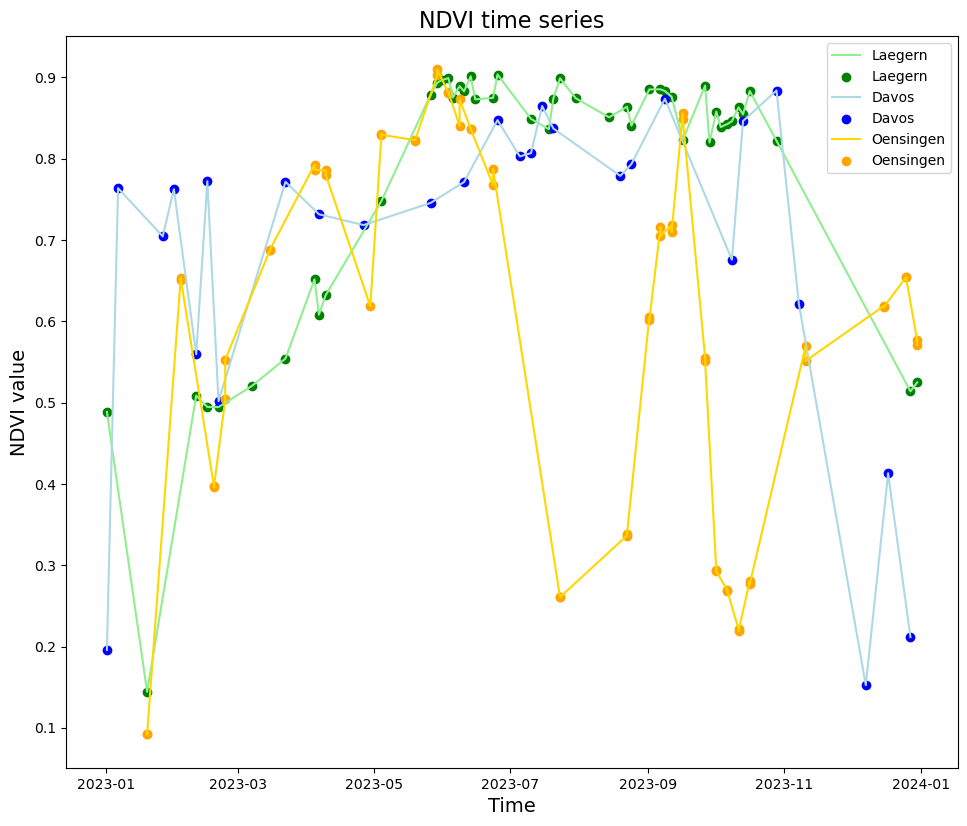

In [166]:
# Visualize the NDVI time series as scatterplot (and connect the points)

fig = plt.figure(figsize=(11.5, 9.5))
plt.plot(df_db['system:time_start'], df_db['NDVI_mean'], color='lightgreen', label='Laegern')
plt.scatter(df_db['system:time_start'], df_db['NDVI_mean'], color='green', label='Laegern')
plt.plot(df_ec['system:time_start'], df_ec['NDVI_mean'], color='lightblue', label='Davos')
plt.scatter(df_ec['system:time_start'], df_ec['NDVI_mean'], color='blue', label='Davos')
plt.plot(df_agr['system:time_start'], df_agr['NDVI_mean'], color='gold', label='Oensingen')
plt.scatter(df_agr['system:time_start'], df_agr['NDVI_mean'], color='orange', label='Oensingen')
plt.title('NDVI time series', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('NDVI value', fontsize=14)
plt.legend()
plt.show()

Instead of only connecting the single points in the time series we can also calculate a smoothed curve using e.g., a polynomial regression LOESS (locally estimated scatterplot smoothing). This helps to show a general trend of the data.

In [167]:
def loess_smoothing(data, smoothing_fraction):

    # Sort the input df by the date for LOWESS
    df_sorted = data.sort_values(by='system:time_start')

    # Convert datetime to a numerical format for LOWESS calculation
    x = mdates.date2num(df_sorted['system:time_start'])
    y = df_sorted['NDVI_mean']

    # Apply LOESS smoothing
    # e.g., frac=0.2 means 20% of data points are used to calculate each smoothed value
    lowess_fit = lowess(y, x, frac=smoothing_fraction)

    # Convert the numerical dates in the smoothed curve back to datetime objects
    x_smoothed = mdates.num2date(lowess_fit[:, 0])
    y_smoothed = lowess_fit[:, 1]

    # Create and return a new df from the smoothed data
    smoothed_df = pd.DataFrame({
        'system:time_start': x_smoothed,
        'NDVI_mean': y_smoothed
    })


    return smoothed_df


In [168]:
db_smoothed = loess_smoothing(df_db, 0.2)
ec_smoothed = loess_smoothing(df_ec, 0.25)
agr_smoothed = loess_smoothing(df_agr, 0.2)

Explanation to the figure:<br>
- As Laegern (aoi_db) is a deciduous forest a clear seasonality signal is expected (no leaves, hence no NDVI in winter).<br>
- The evergreen forest in Davos (aoi_ec) should not show clear seasonality as the needles remain on the spruce trees the whole year. However, we can see high NDVI values in winter, which are due to snow cover and not because of high vegetation activity.<br>
- At the agricultural site in Oensingen (aoi_agr) we can observe multiple drops of NDVI during summer which indicate times when the field was harvested.<br>

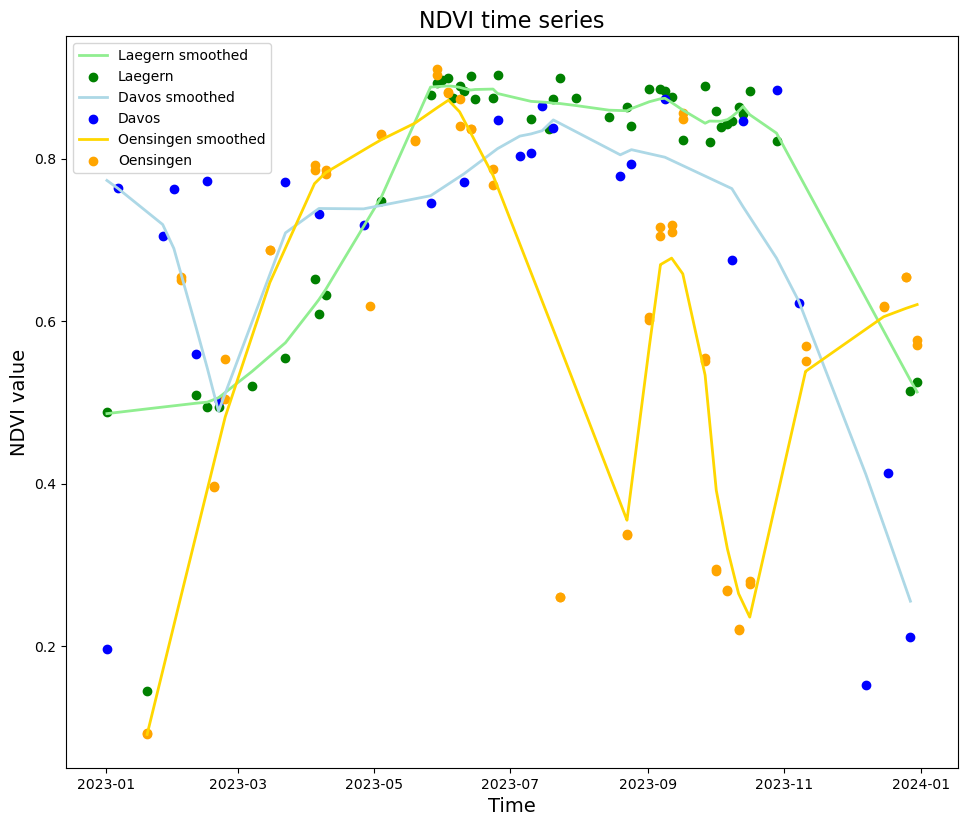

In [169]:
fig = plt.figure(figsize=(11.5, 9.5))

plt.plot(db_smoothed['system:time_start'], db_smoothed['NDVI_mean'], color='lightgreen', linewidth=2, label='Laegern smoothed')
plt.scatter(df_db['system:time_start'], df_db['NDVI_mean'], color='green', label='Laegern')

plt.plot(ec_smoothed['system:time_start'], ec_smoothed['NDVI_mean'], color='lightblue', linewidth=2, label='Davos smoothed')
plt.scatter(df_ec['system:time_start'], df_ec['NDVI_mean'], color='blue', label='Davos')

plt.plot(agr_smoothed['system:time_start'], agr_smoothed['NDVI_mean'], color='gold', linewidth=2, label='Oensingen smoothed')
plt.scatter(df_agr['system:time_start'], df_agr['NDVI_mean'], color='orange', label='Oensingen')

plt.title('NDVI time series', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('NDVI value', fontsize=14)
plt.legend()
plt.show()

*Literature*<br>
$^{[1]}$: Tucker, C.J., 1979. Red and photographic infrared linear combinations for monitoring vegetation. Remote Sensing of Environment 8, 127–150.<br>
$^{[2]}$: https://custom-scripts.sentinel-hub.com/sentinel-2/ndvi/<br>